Plot the number of projects that ask for funding over time in both the npm community and in the larger GitHub community.

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import re
from graphviz import Digraph
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
%matplotlib inline
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
df_all = pd.read_csv('../../data/asking_group_npm_gh.csv')
df_npm = pd.read_csv('../../data/asking_group_npm.csv')

C:\ProgramData\Miniconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (44,45,46,47,48,49,62,63,64) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Get number of projects

In [3]:
print('All:', df_all['slug'].nunique())
print('Npm:', df_npm['slug'].nunique())

All: 28044
Npm: 1243


Get number of projects with multiple services

In [4]:
def get_num_multiple(df):
    services = ['tip4commit', 'salt', 'flattr', 'patreon', 'paypal', 'bountysource',
                'tidelift', 'opencollective', 'liberapay', 'kickstarter']
    num_multiple = 0
    for index, row in df.iterrows():
        has_one = 0
        for service in services:
            if row[service] == 1:
                if has_one == 1:
                    num_multiple += 1
                    break
                else:
                    has_one = 1
    return (num_multiple, num_multiple/df['slug'].nunique())

In [5]:
get_num_multiple(df_all)

(3051, 0.10879332477535301)

In [6]:
get_num_multiple(df_npm)

(505, 0.40627514078841515)

Plot historic figure

In [7]:
def get_counts(df):
    services = ['tip4commit', 'salt', 'flattr', 'patreon', 'paypal', 'bountysource',
                'tidelift', 'opencollective', 'liberapay', 'kickstarter']
    others = ['bountysource', 'issuehunt', 'kickstarter', 'salt', 'otechie', 'tip4commit', 'tidelift']
    counts = {}

    for service in services:
        count = df[service].sum()
        if service in others:
            if 'other' in counts:
                counts['other'] += count
            else:
                counts['other'] = count
        else:
            counts[service] = count
    df_counts = pd.DataFrame(columns=['service', 'count'])
    for service in counts:
        df_counts = df_counts.append({'service':service, 'count':counts[service]}, ignore_index=True)
    df_counts = df_counts.sort_values(by='count', ascending=False)
    return df_counts

In [8]:
def convert_datetime(x):
    if not isinstance(x, str):
        return x
    # Ignore time zone info
    if 'T' in x and 'Z' in x:
        x = x.split('T')[0]
    try:
        temp = datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
    except:
        try:
            temp = datetime.strptime(x, '%Y-%m-%d')
        except:
            try:
                temp = datetime.strptime(x, '%m/%d/%Y')
            except:
                try:
                    temp = datetime.strptime(x, '%m/%d/%Y %H:%M:%S')
                except:
                    temp = datetime.strptime(x, '%m/%d/%Y %H:%M')
    return datetime(temp.year, temp.month, 1)

In [9]:
def get_time_data(service, df):
    df_data = pd.DataFrame(columns=['date', 'count', 'service'])
    if service == 'other':
        df_sub = df[(df['bountysource']==1)|(df['salt']==1)|(df['tip4commit']==1)|(df['tidelift']==1)].copy()
        # Merge other_date columns
        df_sub['other_date'] = df_sub['bountysource_date'].combine_first(df_sub['salt_date'])
        df_sub['other_date'] = df_sub['other_date'].combine_first(df_sub['tip4commit_date'])
        df_sub['other_date'] = df_sub['other_date'].combine_first(df_sub['tidelift_date'])
    else:
        df_sub = df[df[service]==1].copy()
    df_sub['date'] = df_sub[service+'_date'].apply(convert_datetime)
    grouped = df_sub.groupby('date')
    count = 0
    for date, df_date in grouped:
        num_add = df_date['slug'].nunique()
        if num_add < 0:
            print('num_project should not be negative')
            break
        count += num_add
        df_data = df_data.append({'date':date, 'count':count, 'service':service}, ignore_index=True)
    return df_data

In [10]:
def thousands(x, pos):
    return '%1iK' % (x*1e-3)

In [11]:
def plot_time_data(df, formaty=True):
    df_time1 = pd.DataFrame(columns=['date', 'count', 'service'])
    services = ['paypal', 'patreon', 'flattr', 'liberapay', 'opencollective', 'other']
    for service in services:
        df_time1 = df_time1.append(get_time_data(service, df), ignore_index=True)
    markers = {'paypal':'o', 'patreon':'^', 'opencollective':'', 'flattr':'|', 'liberapay':'', 'other':''}
    linestyles = {'paypal':'solid', 'patreon':'solid', 'opencollective':'solid', 'flattr':'solid', 'liberapay':'dashed', 'other':'dotted'}
    hues = {'paypal':'#5D7EA7', 'patreon':'#EFC6D1', 'flattr':'#85BB65', 'liberapay':'#C58293',
       'opencollective':'#9FCDCD', 'other':'#3E3E3C'}
    plt.figure(figsize=(10, 5))
    for service, df_service in df_time1.groupby('service', sort=False):
        plt.plot(df_service['date'].values, df_service['count'].values, label=service, linewidth=2.5, 
                     marker=markers[service], markersize=7, color=hues[service], linestyle=linestyles[service], markevery=3)
    if formaty:
        formatter = FuncFormatter(thousands)
        plt.gca().yaxis.set_major_formatter(formatter)
    plt.legend(loc='upper left', prop={'size': 20}, frameon=False)
    plt.ylabel('Count', fontsize=22, labelpad=15)
    plt.xlim([convert_datetime('2008-01-01'), convert_datetime('2019-05-23')])
    plt.rc('xtick',labelsize=22)
    plt.rc('ytick',labelsize=22)
    sns.despine()
    return plt

Plot for all

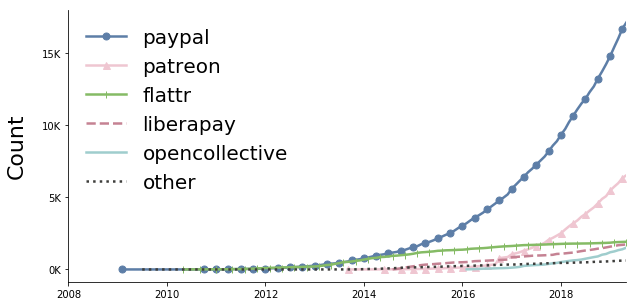

In [12]:
plt = plot_time_data(df_all)

Plot for npm

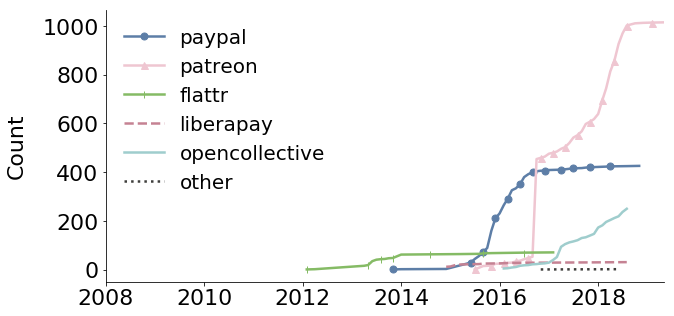

In [13]:
plt = plot_time_data(df_npm, formaty=False)